# Space Invader with Proximal Policy Optimization

## Step 1: Import the libraries

In [1]:
import time
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical

## Step 2: Create our environment

Initialize the environment in the code cell below.


In [2]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('SpaceInvaders-v0')
env.seed(1)
print("Device: ", device)

Device:  cuda


## Step 3: Viewing our Enviroment
Execute the code cell below to play Space Invader with a random policy.

The size of frame is:  (210, 160, 3)
No. of Actions:  6


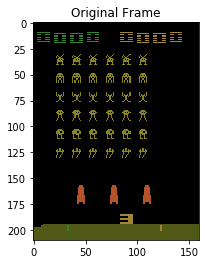

In [3]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()

In [4]:
def random_play():
    env.reset()
    while True:
        env.render()
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        if done:
            env.close()
            break
random_play()

## Step 4:Preprocessing Frame

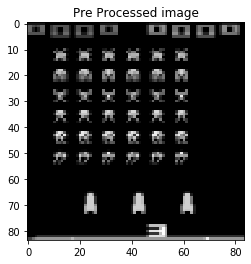

In [5]:
def preprocess_frame(screen):
    # TConver image to gray scale
    screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
    
    #Crop screen[Up: Down, Left: right] 
    screen = screen[8:-12, 4:-12]
    
    # Convert to float, and normalized
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    
    # Resize image to 84 * 84
    screen = cv2.resize(screen, (84, 84), interpolation = cv2.INTER_AREA)
    return screen

env.reset()
plt.figure()
plt.imshow(preprocess_frame(env.reset()), cmap="gray")
plt.title('Pre Processed image')
plt.show()

## Step 5: Stacking Frame

In [6]:
def stack_frame(stacked_frames, state, is_new=False):
    frame = preprocess_frame(state)
    if is_new:
        stacked_frames = np.stack(arrays=[frame, frame, frame, frame])
        stacked_frames = stacked_frames
    else:
        stacked_frames[0] = stacked_frames[1]
        stacked_frames[1] = stacked_frames[2]
        stacked_frames[2] = stacked_frames[3]
        stacked_frames[3] = frame
    
    return stacked_frames

## Step 6: Creating Replay Memory

In [7]:
class ReplayMemory(object):

    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def get(self):
        
        states = torch.from_numpy(np.array(self.states)).float().to(device)
        actions = torch.from_numpy(np.array(self.actions)).long().to(device)
        rewards = torch.from_numpy(np.array(self.discount_and_normalize_rewards(self.rewards))).float().to(device)    
        logprobs = torch.stack(self.logprobs)
        
        return (states, actions, logprobs, rewards)
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]
        
    def discount_and_normalize_rewards(self, episode_rewards):
        discounted_episode_rewards = np.zeros_like(episode_rewards)
        cumulative = 0.0
        for i in reversed(range(len(episode_rewards))):
            cumulative = cumulative * GAMMA + episode_rewards[i]
            discounted_episode_rewards[i] = cumulative

        mean = np.mean(discounted_episode_rewards)
        std = np.std(discounted_episode_rewards)
        discounted_episode_rewards = (discounted_episode_rewards - mean) / (std)

        return discounted_episode_rewards


## Step 7: Creating Deep Learning Model

In [8]:
class Network(nn.Module):
    def __init__(self, num_actions=6):
        super(Network, self).__init__()
        self.action_size = num_actions
        
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, num_actions)
        self.fc6 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        
        if self.action_size == 1:
            return self.fc6(x)
        else:
            return F.softmax(self.fc5(x), dim=1)

In [9]:
GAMMA = .999            # discount factor
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size

class Agent():
    def __init__(self, action_size, alpha=1e-3, beta=3e-3, K_epochs=4, eps_clip=0.2):
        self.action_size = action_size
        self.eps_clip = eps_clip
        
        self.actor_policy = Network(action_size).to(device)
        
        self.actor_target = Network(action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_target.parameters(), lr=alpha)
        self.critic_target = Network(1).to(device)
        self.critic_optimizer = optim.Adam(self.critic_target.parameters(), lr=beta)
        
        self.memory = ReplayMemory()
        self.K_epochs = K_epochs
        self.MseLoss = nn.MSELoss()
                
    def act(self, state):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.actor_policy(state)
        action_probs = Categorical(probs)
        action = action_probs.sample()
        log_prob = action_probs.log_prob(action)
        return action.item(), log_prob
    
    def evaluate(self, states, actions):
        action_probs = self.actor_target(states)
        dist = Categorical(action_probs)
        
        action_logprobs = dist.log_prob(actions)
        dist_entropys = dist.entropy()
        state_values = self.critic_target(states)
        
        return action_logprobs, torch.squeeze(state_values), dist_entropys
    
    def reset(self):
        self.memory.clear_memory()

    
    def step(self, state, action, log_prob, reward, is_terminal):
        self.memory.states.append(state)
        self.memory.actions.append(action)
        self.memory.rewards.append(reward)
        self.memory.logprobs.append(log_prob)
        self.memory.is_terminals.append(is_terminal)
        
    def learn(self):
        old_states, actions, old_logprobs, rewards = self.memory.get()
        
        for _ in range(self.K_epochs):
            logprobs, state_values, dist_entropy = self.evaluate(old_states, actions)
            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())
                
            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            loss.mean().backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
        self.actor_policy.load_state_dict(self.actor_target.state_dict())
        

## Step 9: Watching untrained agent play

In [10]:
agent = Agent(action_size= env.action_space.n)

# watch an untrained agent
state = stack_frame(None, env.reset(), True) 
while True:
    env.render()
    action, _= agent.act(state)
    next_state, reward, done, _ = env.step(action)
    state = stack_frame(state, next_state, False)
    if done:
        break 
        
env.close()

## Step 10: Loading Agent
Uncomment line to load a pretrained agent

In [11]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=100)

# To Load checkpoint uncomment code
# checkpoint = torch.load('space_invader_dqn.pth')
# agent.policy_net.load_state_dict(checkpoint['state_dict'])
# agent.target_net.load_state_dict(checkpoint['state_dict'])
# agent.optimizer.load_state_dict(checkpoint['optimizer'])
# start_epoch = checkpoint['epoch']
# scores = checkpoint['socres']

# index = 1
# for i in reversed(scores):
#     scores_window.append(i)
#     if index == 100:
#         break
#     index += 1

## Step 11: Train the Agent with Actor Critic

In [12]:
def train(n_episodes=2000):
    steps = 0
    for i_episode in range(start_epoch+1, n_episodes+1):
        state = stack_frame(None, env.reset(), True)
        score = 0
        while True:
            action, log_prob = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = stack_frame(state, next_state, False)
            agent.step(state, action, log_prob, reward, done)
            state = next_state
            score += reward
            steps += 1
            if steps == 1000:
                agent.learn()
                agent.reset()
                steps = 0
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    
    return scores

Episode 200	Average Score: 139.75
Episode 300	Average Score: 158.25
Episode 400	Average Score: 162.95
Episode 500	Average Score: 155.95


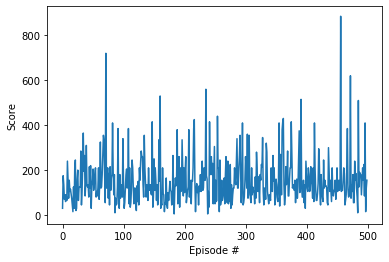

In [19]:
scores = train(500)
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Step 12: Watch a Smart Agent!

In [20]:
score = 0
state = stack_frame(None, env.reset(), True)
while True:
    env.render()
    action, _ = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    score += reward
    state = stack_frame(state, next_state, False)
    if done:
        print("You Final score is:", score)
        break 
env.close()

You Final score is: 320.0


In [15]:
# env.close()